### Class 2

1. Taking Samples
    * Variation of samples 
    * The $1/\sqrt{n}$ law
2. Distributions
    * densities
    * ecdfs
3. Parametric ("analytic") versus nonparametric ("hacker statistics")
    * Confidence Intervals
    * Testing
4. Resampling
    * Permutations
    * Bootstrap
    

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from numpy import random 
random.seed(42)#What is this for ???

In [2]:
# birth weight data
df = pd.read_csv('../data/BirthWeights.csv')[["sex", "dbirwt"]]
df.head()

,sex,dbirwt
0,male,2551
1,male,2778
2,female,2976
3,female,3345
4,female,3175


## Operator Overloading

The [] operator is overloaded. This means, that depending on the inputs, pandas will do something completely different. Here are the rules for the different objects you pass to just the indexing operator.

* string — return a column as a Series
* list of strings — return all those columns as a DataFrame
* a slice — select rows (can do both label and integer location — confusing!)
* a sequence of booleans — select all rows where True

In summary, primarily just the indexing operator selects columns, but if you pass it a sequence of booleans it will select all rows that are `True`.

In [39]:
df = df[(df[ "dbirwt"] < 6000) & (df[ "dbirwt"] > 2000)]

Boxplot of weight vs. sex

,dbirwt
count,5000.00000
mean,3463.59540
std,657.36107
min,481.00000
25%,3118.00000
50%,3459.00000
75%,3827.00000
max,9999.00000


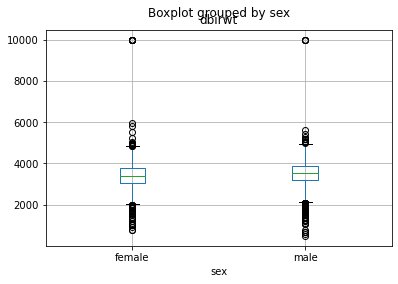

In [8]:
tmp=df.boxplot( "dbirwt","sex")
df.describe()

We notice a small difference in the average weight, which is more clearly visible when we plot overlaying densities for male/female 

sex
female    3427.0
male      3533.0
Name: dbirwt, dtype: float64


3480.0

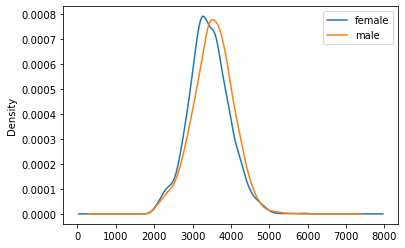

In [45]:
tmp=df[["dbirwt","sex"]].groupby("sex")["dbirwt"].plot(kind='density', legend=True)
bwghtBySex = np.round(df[["dbirwt","sex"]].groupby("sex")["dbirwt"].mean(),0)
print(bwghtBySex)
bwghtBySex.mean()

## A/B Testing

Let us hypothesize that one wanted to classify babies into male/female solely based on their weight. What would its accuracy be if we applied the following simple rule:

if dbirwt > 3480 y = male else y = female

This would be the equivalent of testing for global warming by measuring the temperature on **one** day. We all know that it took a long time (= many samples) to reliably detect a small difference like 0.5 degrees buried in the noise. Let us apply the same idea here. Maybe we can build a high-accuracy classifier if we weighed enough babies separately for each sex. 

In [7]:
#Confusion Matrix for simple classifier:
df["predMale"] = df["dbirwt"] > 3480
pd.crosstab(df["predMale"], df["sex"])


sex,female,male
predMale,,
False,1367,1149
True,1107,1377


In [9]:
Acc0 = (1367+1377)/5000
print("Accuracy of lame classifier:", Acc0)
#Think about the baseline accuracy

Accuracy of lame classifier: 0.5488




#### Tasks

Write a function which

1. draws repeated (e.g. M=500) random samples of size n (e.g. 40, 640) from each sex from the data
2. Computes the stdevs for the sample means of each sex separately
3. Repeats the above density plot for the sample mean distributions
4. computes the confusion matrix/accuracy of a classifier that applies the rule $\bar{x} > 3480$.   
   


In [48]:
#Hint1
np.random.choice(df["dbirwt"],2)

array([3742, 2636], dtype=int64)

In [4]:
def mean_density_comparison(df_cleaned, M=500, n=10):
    
    #Generate an sex iteration array
    sex_iter = ['male', 'female']
    
    #Create an empty DataFrame with 'sex' and 'dbirwt' column
    columns = ['sex', 'dbirwt']
    df_new = pd.DataFrame(columns=columns)
    
    #Create an empty array to store the standard deviation of the differnt sex 'male' = std_dev[0], 'female' = std_dev[1]
    std_dev = np.empty(2)
    
    #Iterate over sex and create a specific data subset
    for ind,v in enumerate(sex_iter):
        subset = df_cleaned[df_cleaned.sex == v]
        
        #create M random sample means of n samples and add it to df_new
        for i in range(M):
            rand_samples = np.random.choice(subset.dbirwt, n)
            x = np.mean(rand_samples)#sample mean per sex
            df_new.loc[len(df_new)+1] = [v, x]
        
        #plot male and female data and calculate the standard deviation of the data
        plot_data = df_new[df_new.sex == v]
        std_dev[ind] = np.std(plot_data['dbirwt'])  
        
        plot_data.dbirwt.plot.density()
        plt.xlabel('dbirwt')
        plt.legend(sex_iter)
		#plt.grid()
		#plt.title("n=" + str(n))
		
    #return the sample mean data
    return df_new
 
        



n=640, means: sex
female    3419.941850
male      3507.383041
Name: dbirwt, dtype: float64
n=640, SESMs: sex
female    25.488923
male      25.544047
Name: dbirwt, dtype: float64
n=40, means: sex
female    3420.65260
male      3513.25225
Name: dbirwt, dtype: float64
n=40, SESMs: sex
female     98.584900
male      104.953466
Name: dbirwt, dtype: float64


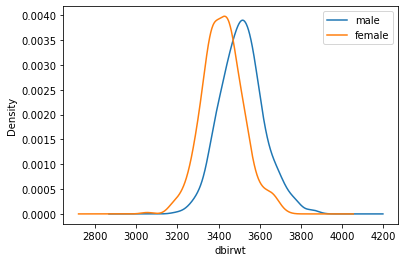

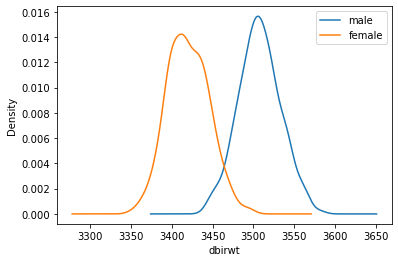

In [5]:
#Test the function
SM40 = mean_density_comparison(df, M=500, n=40)
plt.figure()
SM640 = mean_density_comparison(df, M=500, n=640)

grouped640 = SM640["dbirwt"].groupby(SM40["sex"])
print("n=640, means:", grouped640.mean())
print("n=640, SESMs:", grouped640.std())

SM40.head()
grouped40 = SM40["dbirwt"].groupby(SM40["sex"])
print("n=40, means:", grouped40.mean())
print("n=40, SESMs:", grouped40.std())

How much smaller is $\sigma_{\bar{x},640}$ than $\sigma_{\bar{x},40}$ ?
Compare that factor to the ratio of the sample sizes $640/40 = 16$


The density -like a histogram- has a few complications that include the arbitrary choice of bin width (kernel width for density) and the loss of information. Welcome to the *empirical cumulative distribution function* **ecdf**

In [23]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""

    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y


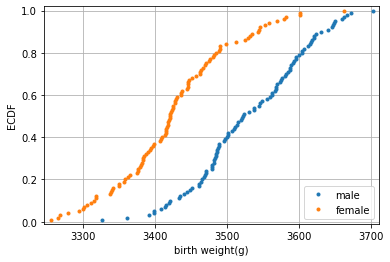

In [58]:
male40 = SM40[SM40.sex == "male"].dbirwt
female40 = SM40[SM40.sex == "female"].dbirwt
# Compute ECDF for sample size 40: m_40, f_40
mx_40, my_40 = ecdf(male40)
fx_40, fy_40 = ecdf(female40)

# Plot all ECDFs on the same plot
_ = plt.plot(mx_40, my_40, marker = '.', linestyle = 'none')
_ = plt.plot(fx_40, fy_40, marker = '.', linestyle = 'none')

# Make nice margins
plt.margins(0.02)

# Annotate the plot
plt.legend(('male', 'female'), loc='lower right')
_ = plt.xlabel('birth weight(g)')
_ = plt.ylabel('ECDF')

# Display the plot
plt.grid()
plt.show()

- What is the relationship to quantiles/percentiles ?
- Find the IQR !
- Sketch the densities just from the ecdf.

### Checking Normality of sample mean distribution

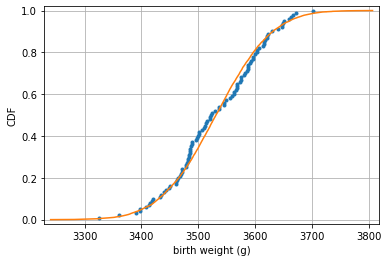

In [59]:
# Compute mean and standard deviation: mu, sigma
mu = np.mean(male40)
sigma = np.std(male40)

# Sample out of a normal distribution with this mu and sigma: samples
samples = np.random.normal(mu, sigma, 10000)

# Get the CDF of the samples and of the data
x_theor, y_theor = ecdf(samples)

# Plot the CDFs and show the plot
_ = plt.plot(mx_40, my_40, marker='.', linestyle='none')
_ = plt.plot(x_theor, y_theor)
plt.margins(0.02)
_ = plt.xlabel('birth weight (g)')
_ = plt.ylabel('CDF')

plt.grid()
plt.show()


### Tasks
1. Find the "5% tails" which are just the (0.05, 0.95) quantiles 
2. Read up on theoretical quantiles: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html#scipy.stats.norm
3. stone age: get the "5% tails" from a normal table.
4. How many stdevs do you need to cover the 90% sample interval ?
5. Can you replace the "empirical theoretical cdf" from above with the exact line without sampling 10000 random numbers from a normal distribution ?


--------------------------------------------------------------
Let us recap what we observed when sampling from a "population": The *sample mean distribution* gets narrower with increasing sample size n, SESM =$\sigma_{\bar{x}} = \sigma/\sqrt{n}$.
Take a look at this [interactive applet](http://onlinestatbook.com/stat_sim/sampling_dist/) for further understanding.

How is this useful ? And how is it relevant because in reality we would only have **one sample**, not hundreds !

#### Small Tasks

1. Choose one random sample of size n=40 from the male babies and compute $\bar{x}$, $\hat{\sigma}$. Assume all that is known to you, are these two *summary statistics*. In particular, we do **not know** the true mean $\mu$!
2. Argue intuitively with the ecdf plot about plausible values of $\mu$.
3. More precisely: what interval around $\bar{x}$ would contain $\mu$ with 90% probability ?


### Hacker Statistic

The ability to draw new samples from a population with a known mean is a luxury that we usually do not have. Is there any way to "fake" new samples using just the one "lousy" sample we have at hand ? 
This might sound like an impossible feat analogously to "pulling yourself up by your own **bootstraps**"!

![BootstrapIlustration](figures/DC_bootstrap_animated.gif  "segment")

But that is exactly what we will try now:


Tasks
0. Look up the help for *np.random.choice()* https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.choice.html
1. Draw repeated samples of size n=40 from the sample above.
2. Compute the mean of each sample and store it an array.
3. Plot the histogram
4. Compute the stdev of this distribution and compare to the SEM.
5. Write a function that computes *bootstrap replicates* of the mean from a sample.
6. Generalize this function to accept any summary statistic, not just the mean.

In [ ]:
def draw_bs_reps_mean(data, size=100):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = np.mean(np.random.choice(data, size=len(data)))

    return bs_replicates


In [16]:
def draw_bs_reps(data, func = np.mean, size=100):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)

    return bs_replicates

def bootstrap_replicate_1d(data, func):
    return func(np.random.choice(data, size=len(data)))

In [19]:
subset = df[df.sex == "male"]
rand_samples_40 = np.random.choice(subset.dbirwt, 40)
xBar = np.mean(rand_samples_40)
rand_samples_40

array([4337, 2552, 3651, 3797, 3713, 4156, 3884, 2551, 3430, 3146, 4592,
       3742, 3685, 3239, 3855, 3798, 2636, 3167, 2780, 3260, 4025, 2636,
       4053, 3203, 3883, 4025, 3090, 3005, 3628, 2637, 3430, 3146, 3487,
       3827, 3543, 3940, 3061, 3600, 3380, 4620], dtype=int64)

In [20]:
# Take 1,000 bootstrap replicates of the mean: bs_replicates
bs_replicates = draw_bs_reps(rand_samples_40, np.mean, size=1000)

In [21]:
bs_replicates[0:10]

array([3505.   , 3556.575, 3487.525, 3331.925, 3548.525, 3489.075,
       3611.2  , 3594.475, 3436.575, 3403.425])

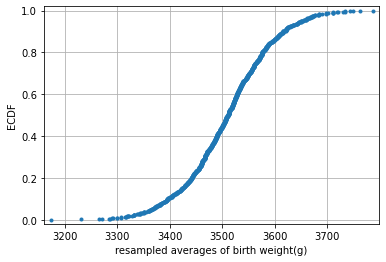

In [24]:
fx_40, fy_40 = ecdf(bs_replicates)

# Plot  ECDF
_ = plt.plot(fx_40, fy_40, marker = '.', linestyle = 'none')

# Make nice margins
plt.margins(0.02)

# Annotate the plot
_ = plt.xlabel('resampled averages of birth weight(g)')
_ = plt.ylabel('ECDF')

# Display the plot
plt.grid()
plt.show()

#### Bootstrap replicates of other statistics

The mean is just one of many sample summaries that we might be interested in. 
Recall the Auto data, in particular the boxplot of mpg ~ cylinders. The graph suggested that not only does the mean mpg seems too decrease with number of cylinders but also the variance.
Let us get **confidence intervals** of the stdev for cyl = 4 and compare to cyl=6. 

**Tasks**
- Generate bootstrap replicates for the stdev of the mpg and plot the histograms and ecdfs of the replicates.
- Argue intuitively whether the stdevs are clearly different.

#### Upcoming Topics

- Linear Regression and bootstrap
    * intercept and slope
    * software reports
- Permutation tests
    * one-sample vs. 2-samples
    * compare with parametric t-test
- Binomial Processes
    * Brownian Motion
    * Variance/Mean
    * Risk as a function of size
